# Matrix free solvers

## Elliptic equation
We here study the general two-dimensional elliptic equation
\begin{align}
-\nabla\cdot( \chi \nabla_\perp \phi) = \rho
\end{align}
which in a two-dimensional Cartesian grid reads
\begin{align}
    -\frac{\partial}{\partial x} \left( \chi(x,y) \frac{\partial}{\partial x} \phi(x,y)\right) - \frac{\partial}{\partial y} \left( \chi(x,y) \frac{\partial}{\partial y} \phi(x,y)\right) = \rho(x,y)
    \label{eq:elliptic2d}
\end{align}
The task is to find a solution for $\phi$ for given $\rho$ and $\chi$.

## Discretization
We use discontinuous Galerkin (dG) methods to discretize
\begin{align}
\partial_x \rightarrow D_x
\end{align}

where $D_x$ is a block-sparse matrix.
We then have
\begin{align}
M \phi &= \rho \label{eq:matrix} \\
M &= D_x^T \chi D_x + D_y^T \chi D_y + J
\end{align}
We here see that $M$ is **self-adjoint**, which means that we can use a **conjugate gradient (CG)** solver.
## Problem

```cpp
// Pseudo-code:
Grid g;
Matrix dx = create_dx (g, bcx), dy = create_dy(g, bcy), j = create_jump();
DiagMatrix diag_chi = create_from_given_vector(chi);
// assembly of M requires four matrix-matrix multiplications and 2 additions
Matrix M = dx.transpose()*diag_chi*dx + dy.transpose()*diag_chi*dy + j;
// Now solve with CG
CG cg;
Vector phi = discretize_phi(g), rho = discretize_rho(g);
cg.solve( M, phi, rho, eps = 1e-8);
```
- In order to assemble $M$ four **matrix-matrix multiplcations** need to be performed
- This **takes longer than the entire CG solve**, at least in our initial tests (admittedly 10 years ago)


## Solution: matrix - free solvers
```{admonition} Matrix-free
A matrix-free solver is any solver for $M x = b$ that does **not require access** to the elements of the matrix $M_{ij}$
```
Matrix-free solvers are thus a subclass of available solvers

Examples of solvers that are **matrix-free**:
- All Krylov-subspace solvers are matrix-free. E.g. conjugate gradient (CG), LGMRES, BICG, etc.
- Fixed point iterations
- Chebyshev iteration


Examples of solvers that are **not matrix-free**
- Direct solvers; need to access $M_{ij}$ directly
- Jacobi iteration; because it needs to decompose $M = D + L + U$
- Gauss-Seidel iteration; needs to decompose $M = L_* + U$

## Example: Main loop of CG algorithm
To solve 
\begin{align}
Mx = b
\end{align}
the main loop of CG reads https://en.wikipedia.org/wiki/Conjugate_gradient_method
\begin{align}
\alpha_k =& \frac{r_k^T \cdot r_k}{p_k^T \cdot ( \color{red}{M \cdot p_k})} \\
x_{k+1} = & x_k + \alpha_k p_k \\
r_{k+1} = & r_k - \alpha_k \color{red}{M \cdot p_k} \\
\beta_k = & \frac{r_{k+1}^T \cdot r_{k+1}}{r_k^T \cdot r_k} \\
p_{k+1} = & r_{k+1} + \beta_k p_k
\end{align}
To implement you only need to implement the **application of $M$ to a vector** rather than $M$ itself
```cpp
Grid g;
Matrix dx = create_dx (g, bcx), dy = create_dy(g, bcy), j = create_jump();
DiagMatrix diag_chi = create_from_given_vector(chi);

// Implement the effet of matrix without ever assembling it
Vector matrix_vector_product_with_elliptic_matrix( Vector phi)
{
    Vector dxP = dx*phi, dyP = dy*phi, JP = j*phi;
    Vector tempX = diag_chi*dxP, tempY = diag_chi*dyP;
    dxP = dx.transpose()*tempX, dy= dy.transpose()*tempY;
    return dxP + dyP + JP;
}

// In main CG loop
Vector Ap= matrix_vector_product_with_elliptic_matrix( p_k);
double alpha = r_old / p*Ap;
x = x + alpha*p;
r = r - alpha*Ap;
r_new = r*r;
double beta = r_new/r_old;
p = r + beta*p;
r_old = r_new;
```

## A manufactured example problem

We manufacture the solution 
\begin{align}
\chi &= 1 + A \sin (x)\sin(y) \\
\rho &= 2 \sin(x) \sin(y) (A\sin(x)\sin(y) +1)- A\sin^2(x)\cos^2(y) - A\cos^2(x)\sin^2(y) \\
\phi &= \sin(x)\sin(y)
\end{align}
for $A\in ]-1,1[$ and solve on the domain $[0,\pi]\times [0,2\pi]$ for Dirichlet boundary conditions in $x$ and periodic in $y$.
The **initital guess is zero**.

### Interface to Feltor from python

We have a C++ program "solvers.cpp" written using the FELTOR library.
- Takes json file as input
- Writes output as yaml

In [1]:
import simplesimdb  # A leightweight data creator and database manager
import numpy as np
import pandas as pd
import yaml # for output files

pd.set_option('display.float_format', lambda x: '%.2e' % x)
# Type make solvers in the repository to have the executable available
database = simplesimdb.Manager( executable='./solvers', directory='data', filetype = 'yaml')

### Create some default input parameters

In [2]:
def create_solver() :
    return {
        "type" : "CG", # CG, LGMRES, BICGSTABl, Multigrid
        "eps" : 1e-6,
        "preconditioner" :{
            "type" : "none" # None or diagonal
        },
        "max_iter" : 10000, # maximum number of iterations
        # for CG
        "check-every" : 1, # errror check every .. iterations
        # for LGMRES
        "inner_m" : 30,
        "outer_k" : 3,
        # for BICGSTABL
        "l_input" : 3
    }


In [3]:
def create_inputfile ():
    '''Create an input file for the solvers FELTOR code'''
    return {
        "grid" : {
            "n" : 3,
            "Nx" : 128, 
            "Ny" : 256,
        },
        "solver" : create_solver(),
        "equations":
        {
            "amp" : 0.9, # The closer to 1 the more difficult!   
        },
        "elliptic" :
        {
            "jfactor" : 1,
            "direction" : "forward" # forward or centered

        }    
    }

### Some basic setup

In [4]:
# Clean out all existing simulations
database.delete_all()
database.directory='data'

In [5]:
def make_dataframe():
    '''Make a pandas Dataframe of all simulations in the database
    
    Concatenates all inputs and outputs as serialized dicts
    '''
    inputs  = list()
    outputs =list()
    for data in database.table() :
        inputs.append( data)
        with open( database.outfile( data)) as f:
            output = yaml.full_load(f)
            outputs.append( output)
    dfi = pd.json_normalize(inputs)        
    dfo = pd.json_normalize(outputs)
    return pd.concat([dfi, dfo], axis=1)

### Our first solver test: Unpreconditioned CG on a Nvidia Titan Xp

In [6]:
# Create an inputfile
inputfile = create_inputfile()

# Run a simulation
outputfile=database.create( inputfile)

# Read in the outputfile (yaml in this case)
with open(outputfile) as f:
    output = yaml.full_load(f)

# Print
print(inputfile)
print(output)

Running simulation b93b81...04ff.yaml
{'grid': {'n': 3, 'Nx': 128, 'Ny': 256}, 'solver': {'type': 'CG', 'eps': 1e-06, 'preconditioner': {'type': 'none'}, 'max_iter': 10000, 'check-every': 1, 'inner_m': 30, 'outer_k': 3, 'l_input': 3}, 'equations': {'amp': 0.9}, 'elliptic': {'jfactor': 1, 'direction': 'forward'}}
{'time': 2.57893, 'iter': 4133, 'error': 8.07962e-08, 'error_abs': 1.79484e-07}


### Let us print this in a nicer way

In [7]:
# Use Pandas to analyse the data in a nice way
df = make_dataframe()  
df[['solver.type','solver.preconditioner.type','grid.n','grid.Nx','grid.Ny','iter','time']]


,solver.type,solver.preconditioner.type,grid.n,grid.Nx,grid.Ny,iter,time
0,CG,none,3,128,256,4133,2.58e+00


# Preconditioners in a matrix-free solver

Problem: since the matrix elements are un-known the preconditioner also needs to be **matrix-free**

We guess:
\begin{align}
M^{-1} \approx \frac{1}{\chi}
\end{align}
Diagonal preconditioner



In [8]:
inputfile = create_inputfile()
inputfile["solver"]["preconditioner"]['type'] = 'diagonal'

database.create( inputfile)

df = make_dataframe()  
df[['solver.type','solver.preconditioner.type','grid.n','grid.Nx','grid.Ny','iter','time']]

Running simulation e915df...b01f.yaml


,solver.type,solver.preconditioner.type,grid.n,grid.Nx,grid.Ny,iter,time
0,CG,none,3,128,256,4133,2.58e+00
1,CG,diagonal,3,128,256,2097,1.29e+00


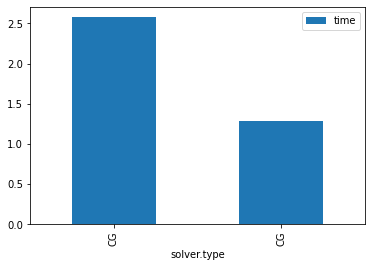

In [9]:
ax = df.plot.bar(x='solver.type',y="time")

# How do other Krylov-solvers fare against CG?

### LGMRES

In [10]:
inputfile = create_inputfile()
inputfile["solver"]["preconditioner"]['type'] = 'diagonal'
inputfile["solver"]["type"] = "LGMRES"

database.create( inputfile)
# df = make_dataframe()
# df["time_per_iter"] = df["time"]/df["iter"]
# dff = df[['solver.type','solver.preconditioner.type','grid.n','grid.Nx','grid.Ny',
#           'iter','time','time_per_iter','error']]
# dff

Running simulation be703b...2384.yaml


'data/be703b830d2db17aea88449965230a8d5e722384.yaml'

### BICGSTABl

In [11]:
inputfile = create_inputfile()
inputfile["solver"]["preconditioner"]['type'] = 'diagonal'
inputfile["solver"]["type"] = "BICGSTABl"

database.create( inputfile)

df = make_dataframe()
df['time_per_iter'] =  df["time"]/df["iter"]
dff = df[['solver.type','solver.preconditioner.type','grid.n','grid.Nx','grid.Ny','iter','time','time_per_iter']]
dff

Running simulation 2864bf...379b.yaml


,solver.type,solver.preconditioner.type,grid.n,grid.Nx,grid.Ny,iter,time,time_per_iter
0,BICGSTABl,diagonal,3,128,256,1374,1.69e+00,1.23e-03
1,CG,none,3,128,256,4133,2.58e+00,6.24e-04
2,LGMRES,diagonal,3,128,256,5229,1.33e+01,2.54e-03
3,CG,diagonal,3,128,256,2097,1.29e+00,6.13e-04


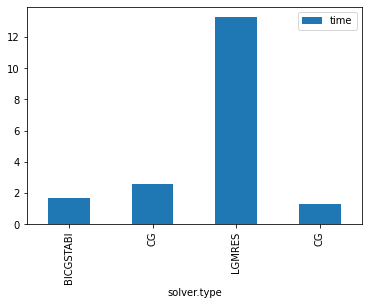

In [12]:
ax = df.plot.bar(x='solver.type',y="time")

 ### Observations
 - LGMRES is almost a **factor 10** worse than CG **for this problem** (other problems may have different results)
 - BICGSTABl fares almost as well as normal CG

# Matrix-free (geometric) multigrid

Classical multigrid consists of three ingredients [*Briggs, W.L., Henson, V.E., and McCormick, S.F. (2000) A multigid tutorial*]
- A grid restriction/prolongation 
- A (direct) solver on the coarsest grid
- A smoother on the other grids

With matrix-free (dG) solvers:
- restriction/prolongation is straightforward
- A direct solver is **inadmissable**
- Most smoothers (e.g. Gauss-Seidel) are **not matrix-free**

## A first attempt: Nested iterations

IDEA:
- project initial guess to coarsest grid
- solve with PCG up to accuracy
- interpolate solution to next fine grid
- solve with PCG (with interpolated solution as initial guess)
- ...

This employs ideas from "Full approximation scheme" and **also works for nonlinear problems**

[*Van Emden Henson "Multigrid methods for nonlinear problems: an overview", Proc. SPIE 5016, Computational Imaging, (1 July 2003);*]

In [13]:
def create_multigrid_inputfile():
    return {
        "grid" : {
            "n" : 3,
            "Nx" : 128, 
            "Ny" : 256,
        },
        "solver" : 
        {
            "type" : "Multigrid-FAS", # Full approximation scheme
            "num_stages" : 3,
            "solvers" :
            [
                create_solver(), # Solver on stage 0 (the fine grid)
                create_solver(), # Solver on stage 1 (the next grid)
                create_solver()  # Solver on stage 2 (the coarse grid)
            ]      
        },
        "equations":
        {
            "amp" : 0.9, # The closer to 1 the more difficult   
        },
        "elliptic" :
        {
            "jfactor" : 1,
            "direction" : "forward" # forward or centered

        }    
    }


In [14]:
inputfile = create_multigrid_inputfile()
for i in (0,1,2):
    inputfile['solver']['solvers'][i]['preconditioner']['type'] = 'diagonal'
inputfile['solver']['preconditioner'] = {'type': 'diagonal'}

database.create( inputfile, error = 'display')

df = make_dataframe()
df["time_per_iter"] = df["time"]/df["iter"]
dff = df[['solver.type','solver.preconditioner.type','grid.n','grid.Nx','grid.Ny',
          'iter','time','time_per_iter', 'error']]
dff

Running simulation d256ed...8dd1.yaml


,solver.type,solver.preconditioner.type,grid.n,grid.Nx,grid.Ny,iter,time,time_per_iter,error
0,BICGSTABl,diagonal,3,128,256,1374,1.69e+00,1.23e-03,1.05e-06
1,CG,none,3,128,256,4133,2.58e+00,6.24e-04,8.08e-08
2,LGMRES,diagonal,3,128,256,5229,1.33e+01,2.54e-03,7.28e-07
3,Multigrid-FAS,diagonal,3,128,256,76,1.51e-01,1.98e-03,8.34e-08
4,CG,diagonal,3,128,256,2097,1.29e+00,6.13e-04,8.23e-08


(0.1, 20)

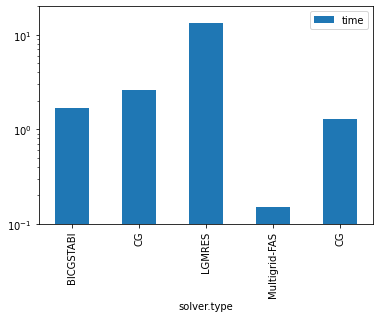

In [15]:
ax = df.plot.bar(x='solver.type',y="time")
ax.set_yscale('log')
ax.set_ylim([0.1,20])

## Fine-tuning: Avoiding scalar products on coarse grid

On a cluster the most time-consuming operation is the scalar product on the coarse grid.
**Avoid error check at every iteration**.

In [16]:
inputfile = create_multigrid_inputfile()
for i in (0,1,2):
    inputfile['solver']['solvers'][i]['check-every'] = 10 # only check error at every 10-th iteration 
    if( i==0 ) : 
        inputfile['solver']['solvers'][i]['check-every'] = 1 
    inputfile['solver']['solvers'][i]['preconditioner']['type'] = 'diagonal'
    inputfile['solver']['preconditioner'] = {'type': 'diagonal'}
database.recreate( inputfile, error = 'display')

df = make_dataframe()
df["time_per_iter"] = df["time"]/df["iter"]
dff = df[['solver.type','solver.preconditioner.type','grid.n','grid.Nx','grid.Ny',
          'iter','time','time_per_iter','error']]
dff

Running simulation 67f4ad...88eb.yaml


,solver.type,solver.preconditioner.type,grid.n,grid.Nx,grid.Ny,iter,time,time_per_iter,error
0,BICGSTABl,diagonal,3,128,256,1374,1.69e+00,1.23e-03,1.05e-06
1,Multigrid-FAS,diagonal,3,128,256,76,1.31e-01,1.72e-03,8.22e-08
2,CG,none,3,128,256,4133,2.58e+00,6.24e-04,8.08e-08
3,LGMRES,diagonal,3,128,256,5229,1.33e+01,2.54e-03,7.28e-07
4,Multigrid-FAS,diagonal,3,128,256,76,1.51e-01,1.98e-03,8.34e-08
5,CG,diagonal,3,128,256,2097,1.29e+00,6.13e-04,8.23e-08


(0.1, 20)

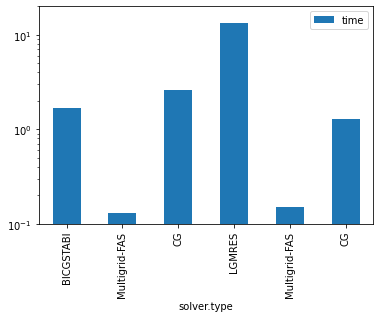

In [17]:
ax = dff.plot.bar(x='solver.type',y="time")
ax.set_yscale('log')
ax.set_ylim([0.1,20])

## Matrix-free Full multigrid

Matrix-free Full multigrid is possible using 
- use Chebyshev iterations as smoother
- use CG on coarse grid as solver

BUT
- no performance improvement over nested iterations (in our tests)
- sometimes does not converge at all


#  Conclusions
- Matrix-free solvers **avoid assembly cost** of matrix
- CG solver can have large speedup **(up to 10x) over LGMRES** for symmetric problems
- **Matrix-free multigrid possible** and large speedup (another 10x) over non-multigrid